# Recurrent Neural Networks and The Yield Curve 

Objectives:
- Learning Multistep, multifeature time series modelling
- Naive Bayes  -> Advanced RNN (GRU)

Today we will be exploring yield curves spreads and using data from **Quandl**. Quandl offers quick and easy API's to use and retrieve for free, and already in DataFrame form. Who says a free lunch doesn't exist!


- Here is the data: https://www.quandl.com/data/USTREASURY/YIELD-Treasury-Yield-Curve-Rates
- Here is a tutorial to install Quandl: https://www.quandl.com/tools/python

In [409]:
import tensorflow as tf
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping


import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import statsmodels.api as sm
import pandas as pd

In [2]:
import quandl
df = quandl.get("USTREASURY/YIELD", authtoken="s-LF8xGE9kdc-bsVjrUN")

In [3]:
df.head(5)

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,,,
1990-01-02,NaN,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,NaN,8.00
1990-01-03,NaN,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04
1990-01-04,NaN,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04
1990-01-05,NaN,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06
1990-01-08,NaN,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09


In [4]:
# This is method is equivalent to washing your hands in Covid-19... ALWAYS AND OFTEN!
df.describe()

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
count,4780.000000,475.000000,7676.000000,7679.000000,7679.000000,7679.000000,7679.000000,7679.000000,7679.000000,7679.000000,6740.000000,6685.000000
mean,1.267393,1.539705,2.727212,2.856770,2.981999,3.280628,3.495967,3.888052,4.192895,4.428889,4.524534,4.967156
std,1.471468,0.921334,2.286094,2.320731,2.320446,2.342598,2.292637,2.178817,2.088541,1.980369,1.663439,1.913456
min,0.000000,0.000000,0.000000,0.020000,0.080000,0.110000,0.100000,0.190000,0.360000,0.520000,0.870000,0.990000
25%,0.070000,0.175000,0.240000,0.420000,0.560000,0.940000,1.380000,1.825000,2.240000,2.650000,2.910000,3.120000
50%,0.880000,1.860000,2.350000,2.460000,2.570000,2.950000,3.260000,3.780000,4.050000,4.330000,4.660000,4.780000
75%,1.912500,2.370000,4.990000,5.110000,5.110000,5.370000,5.510000,5.730000,5.940000,5.950000,5.830000,6.490000
max,5.270000,2.480000,8.260000,8.490000,8.640000,9.050000,9.110000,9.100000,9.120000,9.090000,8.300000,9.180000


We are going to drop a couple features (Maturities). In specfic: the 1 month, the 2 month and 30 year. The 1 month was created in '01, the 30 year was removed in '01 and brought back in. Anyhow, sparse data makes things a little more confusing for time series modelling so we are going to remove them. 

In [5]:
type(df)

pandas.core.frame.DataFrame

In [6]:
df = df.drop(['1 MO','2 MO','30 YR'], axis = 1)
df = df.dropna(axis = 0)

In [7]:
df

,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR
Date,,,,,,,,,
1993-10-01,2.98,3.11,3.35,3.84,4.18,4.72,5.03,5.34,6.12
1993-10-04,3.02,3.17,3.35,3.85,4.16,4.71,5.04,5.34,6.10
1993-10-05,3.06,3.20,3.38,3.86,4.18,4.72,5.05,5.35,6.12
1993-10-06,3.04,3.19,3.36,3.85,4.16,4.70,5.05,5.35,6.12
1993-10-07,3.05,3.17,3.35,3.83,4.15,4.69,5.05,5.33,6.11
...,...,...,...,...,...,...,...,...,...
2020-09-02,0.12,0.12,0.13,0.14,0.16,0.26,0.45,0.66,1.16
2020-09-03,0.11,0.12,0.12,0.13,0.15,0.24,0.43,0.63,1.13
2020-09-04,0.11,0.12,0.13,0.14,0.18,0.30,0.50,0.72,1.25


In [8]:
df['3 MO'].mean() + df['3 MO'].std() 

4.535613558922364

In [9]:
df['3 MO'].quantile(0.6)

2.79

In [10]:
df.index.year

Int64Index([1993, 1993, 1993, 1993, 1993, 1993, 1993, 1993, 1993, 1993,
            ...
            2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020],
           dtype='int64', name='Date', length=6737)

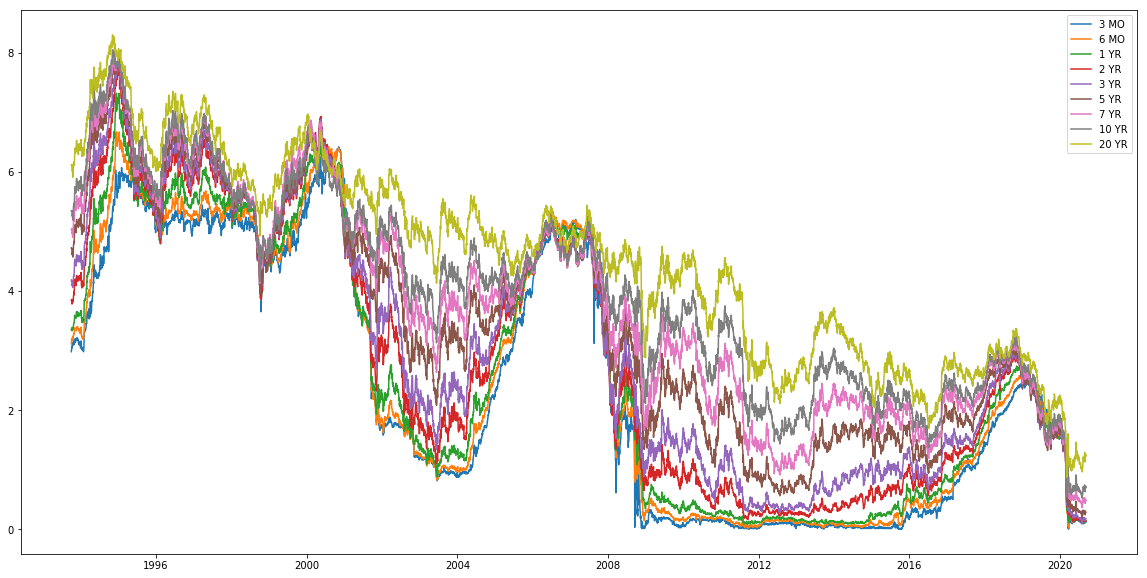

In [11]:
plt.figure(figsize=(20,10));
plt.plot(df);
plt.legend(df);

Separate it a bit more

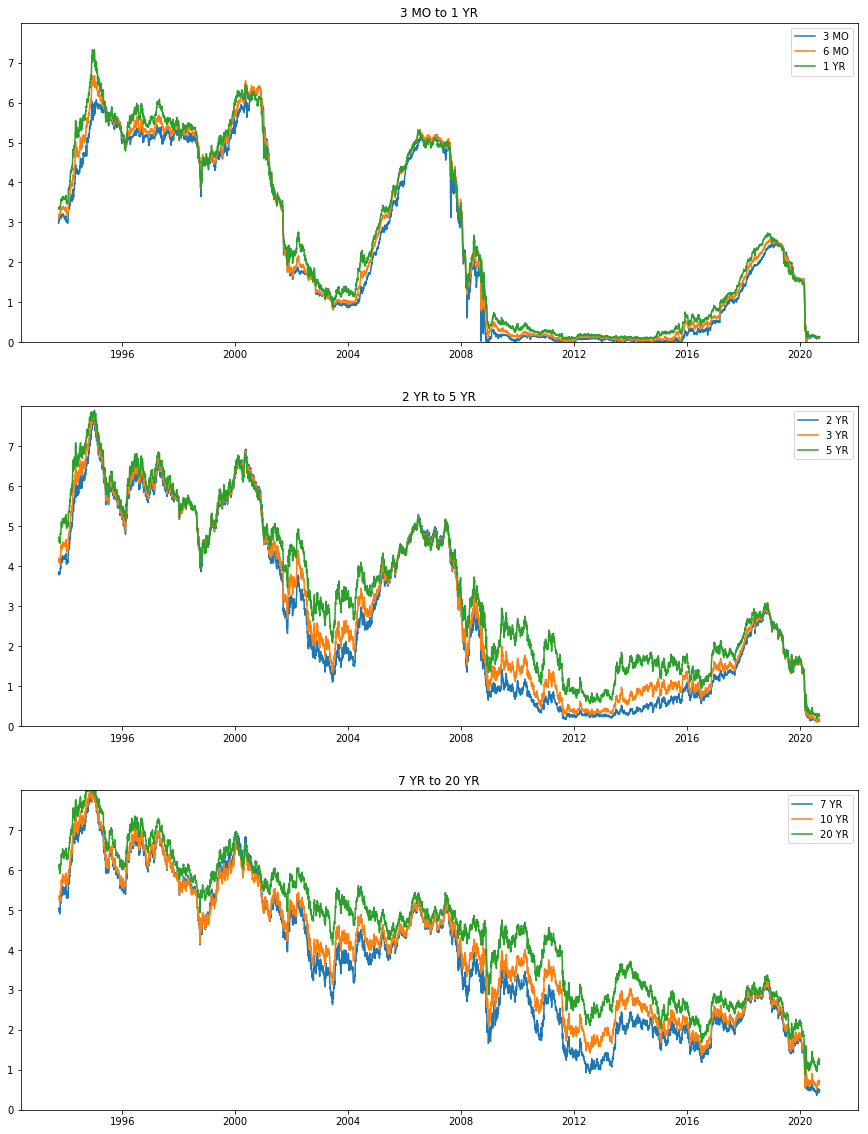

In [12]:
f, axes = plt.subplots(3, 1, figsize=(15, 20))

j = 0
while j < 3:
    for i in range(0,len(df.columns),3):
        new = df.iloc[:,i:i+3]
        axes[j].set_ylim((0,8))
        axes[j].set_yticks(np.arange(0, 8, 1))
        axes[j].set_title(f"{new.columns[0]} to {new.columns[-1]}")
        axes[j].plot(new, label = new.columns)
        axes[j].legend(new)
    
        j += 1

### Yearly Yield curve plots
- Lets plot the yield curve over an annual basis. 
- 2 Steps:
1. Groupby year and take the mean value
2. Transpose the dataset

In [13]:
dfyear = df.groupby(df.index.year).mean()
dfystd = df.groupby(df.index.year).std()

In [14]:
dfyear

,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR
Date,,,,,,,,,
1993,3.132903,3.306290,3.528710,4.085000,4.408710,4.977903,5.333387,5.615968,6.285968
1994,4.372490,4.826506,5.317470,5.942972,6.270442,6.688273,6.907711,7.085181,7.490080
1995,5.660360,5.817560,5.942120,6.151440,6.254720,6.383320,6.496440,6.573920,6.954640
1996,5.145595,5.290635,5.515913,5.844960,5.994802,6.182103,6.343770,6.443532,6.826111
1997,5.201440,5.390160,5.631520,5.990880,6.102960,6.224680,6.326920,6.353960,6.686840
1998,4.906960,5.020160,5.052520,5.130520,5.137920,5.152320,5.278640,5.262880,5.715960
1999,4.777211,4.945817,5.083108,5.434303,5.492948,5.550040,5.786255,5.646135,6.197809
2000,5.999920,6.173984,6.112948,6.260916,6.220598,6.157769,6.200518,6.030279,6.230916
2001,3.478669,3.453065,3.490000,3.830887,4.089274,4.556694,4.881653,5.020685,5.632177


In [15]:
dfyear.head(5)
dfpct = dfyear.pct_change()
dfpct.dropna(axis = 0)

,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR
Date,,,,,,,,,
1994,0.395667,0.459795,0.506916,0.454828,0.422285,0.343592,0.295183,0.261614,0.191556
1995,0.294539,0.205336,0.117471,0.035078,-0.002507,-0.045595,-0.059538,-0.072159,-0.071487
1996,-0.090942,-0.090575,-0.071726,-0.049822,-0.041556,-0.031522,-0.023501,-0.019834,-0.018481
1997,0.010853,0.018812,0.020959,0.024965,0.018042,0.006887,-0.002656,-0.013901,-0.020403
1998,-0.056615,-0.068644,-0.102814,-0.143612,-0.158127,-0.172276,-0.165686,-0.171717,-0.145193
1999,-0.026442,-0.014809,0.006054,0.059211,0.069100,0.077192,0.096164,0.072822,0.084299
2000,0.255946,0.248324,0.202601,0.152110,0.132470,0.109500,0.071594,0.068037,0.005342
2001,-0.420214,-0.440707,-0.429081,-0.388127,-0.342624,-0.260009,-0.212702,-0.167421,-0.096092
2002,-0.529901,-0.502911,-0.426395,-0.311449,-0.241939,-0.162612,-0.118209,-0.081185,-0.035613


In [16]:
dfpct.index[-1:]

Int64Index([2020], dtype='int64', name='Date')

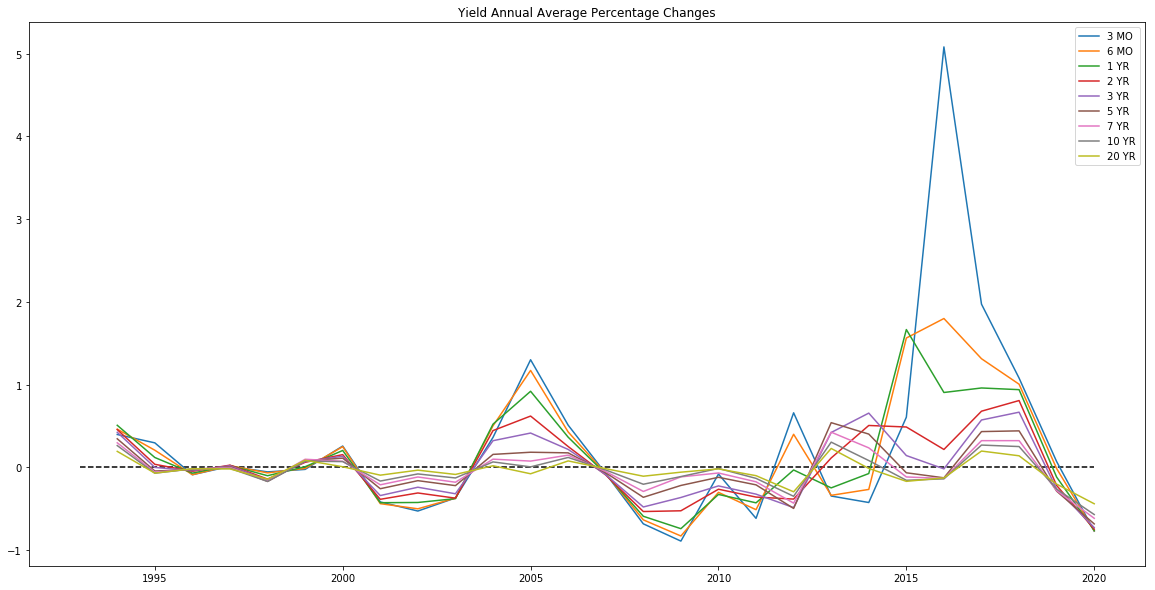

In [17]:
plt.figure(figsize=(20,10));
plt.hlines(y=0, xmin = dfpct.index[0], xmax = dfpct.index[-1:], colors='black', linestyles='--', data = dfpct)
plt.plot(dfpct);
plt.legend(df);
plt.title("Yield Annual Average Percentage Changes");

This jump in 2015 may look noteworthy but be weary, the 3 month yield was near bottomed-out (Known as The Zero Lower Bound). A 508% increase only lifted rates approximately 25 basis points. 

In [18]:
dfystd.head(5) #Volatility

,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR
Date,,,,,,,,,
1993,0.050777,0.070181,0.101731,0.155213,0.172165,0.202072,0.209041,0.210421,0.167826
1994,0.798743,0.927014,1.008228,0.978855,0.930071,0.806113,0.725545,0.665725,0.549137
1995,0.221006,0.351246,0.525907,0.656932,0.680560,0.681138,0.653812,0.630063,0.568746
1996,0.101766,0.158970,0.283406,0.412689,0.440883,0.442621,0.419016,0.403634,0.354751
1997,0.102555,0.112860,0.175028,0.234276,0.271121,0.305811,0.312417,0.337215,0.343594


In [19]:
yieldcurvestd = dfystd.T 
yieldcurvestd

Date,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
3 MO,0.050777,0.798743,0.221006,0.101766,0.102555,0.359078,0.297304,0.265588,1.116287,0.189192,...,0.047916,0.021913,0.025426,0.013848,0.065651,0.085153,0.244715,0.294299,0.336178,0.600849
6 MO,0.070181,0.927014,0.351246,0.158970,0.112860,0.373829,0.366975,0.201352,1.065265,0.239987,...,0.050353,0.024124,0.023533,0.019636,0.129732,0.079997,0.249673,0.278445,0.357119,0.586006
1 YR,0.101731,1.008228,0.525907,0.283406,0.175028,0.443142,0.385703,0.187331,0.887453,0.376551,...,0.069172,0.023732,0.017165,0.034308,0.130983,0.108397,0.252874,0.279459,0.386050,0.553239
2 YR,0.155213,0.978855,0.656932,0.412689,0.234276,0.514566,0.445856,0.387246,0.699559,0.636042,...,0.208644,0.035563,0.059177,0.091342,0.132113,0.150979,0.192446,0.259540,0.385958,0.528171
3 YR,0.172165,0.930071,0.680560,0.440883,0.271121,0.507353,0.461298,0.416417,0.571981,0.723426,...,0.350387,0.059765,0.157305,0.117959,0.128306,0.204619,0.157294,0.231089,0.386051,0.509394
5 YR,0.202072,0.806113,0.681138,0.442621,0.305811,0.526838,0.482092,0.442287,0.379573,0.700338,...,0.527494,0.126960,0.341822,0.091374,0.138051,0.256950,0.131895,0.174009,0.390135,0.478124
7 YR,0.209041,0.725545,0.653812,0.419016,0.312417,0.466201,0.506381,0.424276,0.326441,0.618093,...,0.594196,0.186113,0.421110,0.121477,0.156872,0.277623,0.117261,0.159978,0.390477,0.445272
10 YR,0.210421,0.665725,0.630063,0.403634,0.337215,0.424912,0.475559,0.391931,0.285667,0.536607,...,0.626627,0.205378,0.413890,0.198238,0.166284,0.283955,0.108628,0.155953,0.402192,0.416596
20 YR,0.167826,0.549137,0.568746,0.354751,0.343594,0.275368,0.394280,0.315021,0.213432,0.380278,...,0.671842,0.228110,0.387958,0.282485,0.202224,0.288214,0.105597,0.151695,0.364554,0.359076


In [20]:
yieldcurvesdf = dfyear.T
yieldcurvesdf


Date,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
3 MO,3.132903,4.372490,5.66036,5.145595,5.20144,4.90696,4.777211,5.999920,3.478669,1.63532,...,0.05284,0.08760,0.05708,0.03272,0.052510,0.31936,0.94896,1.971687,2.10576,0.477586
6 MO,3.306290,4.826506,5.81756,5.290635,5.39016,5.02016,4.945817,6.173984,3.453065,1.71648,...,0.09572,0.13384,0.08832,0.06460,0.165498,0.46304,1.07044,2.144819,2.10944,0.488621
1 YR,3.528710,5.317470,5.94212,5.515913,5.63152,5.05252,5.083108,6.112948,3.490000,2.00188,...,0.18088,0.17484,0.13116,0.12112,0.322709,0.61432,1.20288,2.330843,2.05212,0.482241
2 YR,4.085000,5.942972,6.15144,5.844960,5.99088,5.13052,5.434303,6.260916,3.830887,2.63776,...,0.44936,0.27616,0.30708,0.46208,0.686773,0.83420,1.39920,2.527068,1.96880,0.495747
3 YR,4.408710,6.270442,6.25472,5.994802,6.10296,5.13792,5.492948,6.220598,4.089274,3.09992,...,0.74676,0.38228,0.54284,0.89796,1.024542,1.00400,1.57720,2.626627,1.93756,0.523793
5 YR,4.977903,6.688273,6.38332,6.182103,6.22468,5.15232,5.550040,6.157769,4.556694,3.81572,...,1.51824,0.76172,1.17208,1.64160,1.531036,1.33472,1.90964,2.748996,1.95300,0.614080
7 YR,5.333387,6.907711,6.49644,6.343770,6.32692,5.27864,5.786255,6.200518,4.881653,4.30460,...,2.15684,1.22044,1.73752,2.14404,1.891195,1.63432,2.15892,2.852209,2.04544,0.782184
10 YR,5.615968,7.085181,6.57392,6.443532,6.35396,5.26288,5.646135,6.030279,5.020685,4.61308,...,2.78164,1.80344,2.35016,2.53956,2.138287,1.83744,2.32948,2.911245,2.14140,0.916149
20 YR,6.285968,7.490080,6.95464,6.826111,6.68684,5.71596,6.197809,6.230916,5.632177,5.43160,...,3.61756,2.54180,3.11828,3.07264,2.547530,2.21860,2.65196,3.018233,2.40132,1.340057


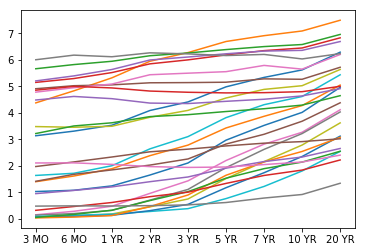

In [21]:
plt.plot(yieldcurvesdf);

A little difficult to decipher which is where, lets separate this into subplots. How about 7 plots with 4 lines each?

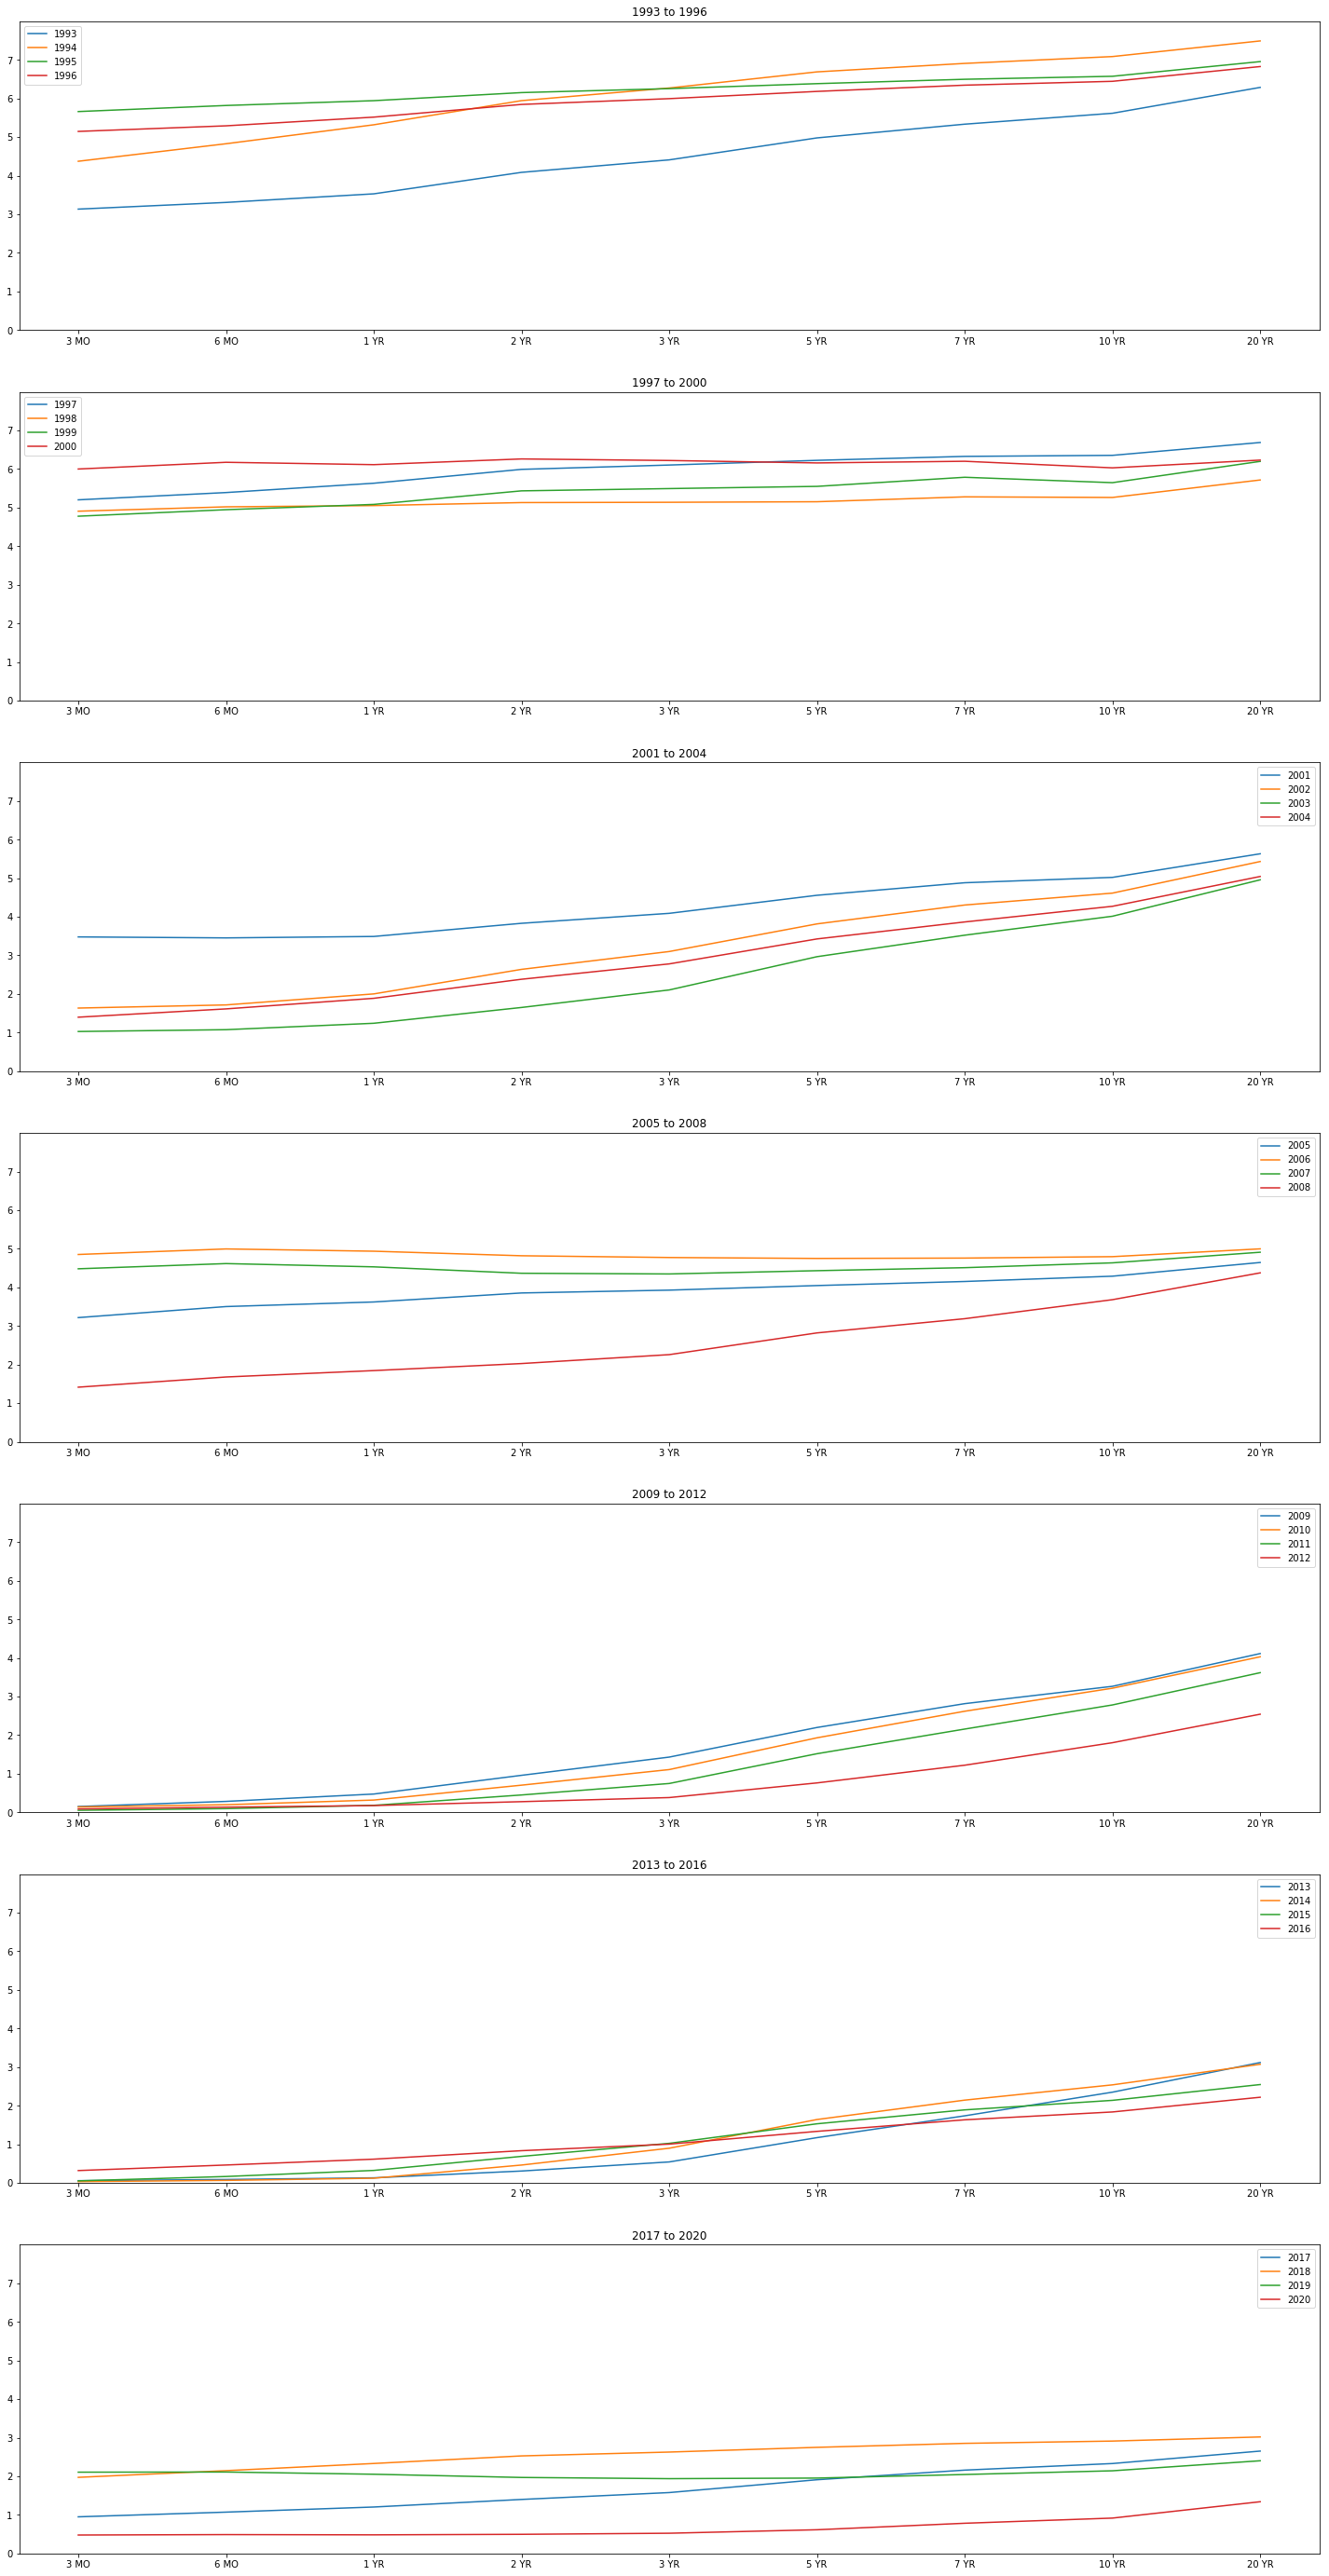

In [22]:
f, axes = plt.subplots(7, 1, figsize=(25, 50))
j = 0
while j < 7:
    for i in range(0,len(dfyear),4):
        new = yieldcurvesdf.iloc[:,i:i+4]
        axes[j].set_ylim((0,8))
        axes[j].set_yticks(np.arange(0, 8, 1))
        axes[j].set_title(f"{new.columns[0]} to {new.columns[-1]}")
        axes[j].plot(new, label = new.columns)
        axes[j].legend(new)
        
        j += 1

This is a good generalization of the yield curve for each year, but lets add a `fill_between` of 1 standard deviation for each maturity at each given year 

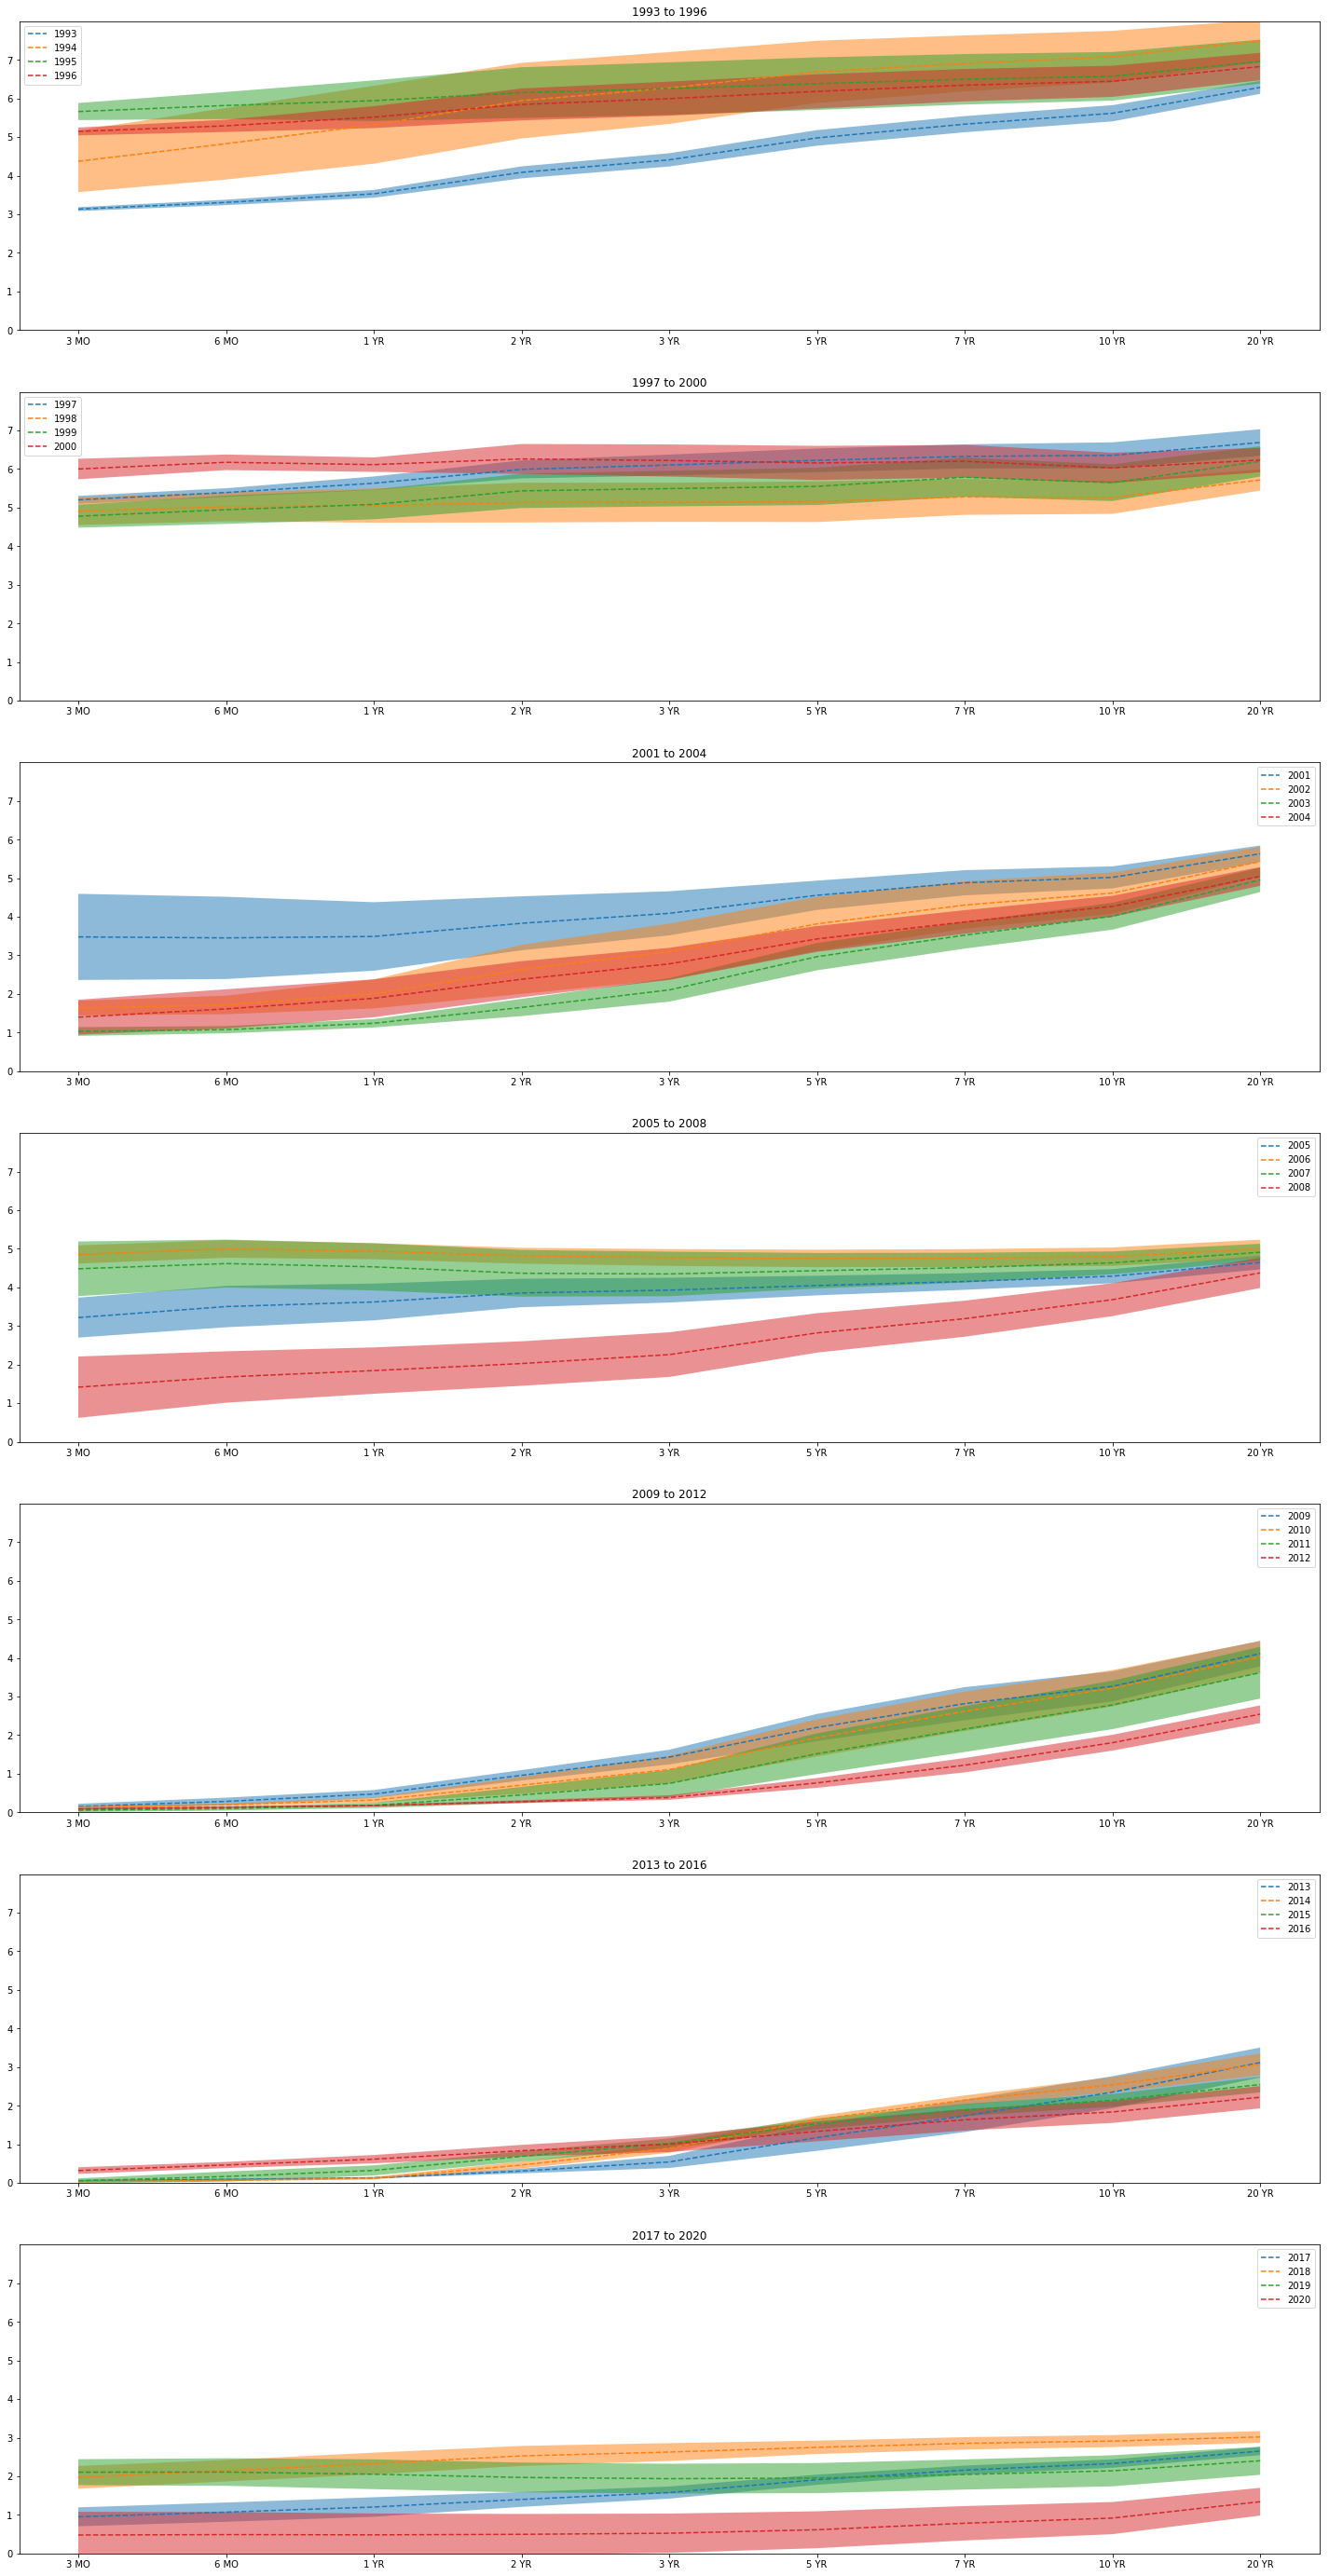

In [23]:
f, axes = plt.subplots(7, 1, figsize=(25, 50))
j = 0
while j < 7:
    for i in range(0,len(dfyear),4):
        temp = yieldcurvesdf.iloc[:,i:i+4]
        temp2 = yieldcurvestd.iloc[:,i:i+4]
        axes[j].set_ylim((0,8))
        axes[j].set_yticks(np.arange(0, 8, 1))
        axes[j].set_title(f"{temp.columns[0]} to {temp.columns[-1]}")
        axes[j].plot(temp, linestyle = '--')
        for k in range(4):
            axes[j].fill_between(x = yieldcurvesdf.index, y1 = temp.values[:,k] + temp2.values[:,k], y2 = temp.values[:,k] - temp2.values[:,k],
                                alpha=0.5, label = '± σ')
        axes[j].legend(temp)
        
        j += 1

## Interpretation of The Yield Curve

This plot offers a lot of fundamental information about the macroeconomic climate. For example, one can observe multiple differences in

**Level** - A parallel increase or decrease in the interest rates.

**Steepness** - Long term interest rates increased while short term rates decreased. 

**Curvature** - Short term and long term increases while intermediate term has little change

Also, we have plotted a 
`average rate ± σ `for each individual year to observe the annual volatilty. For example, 2001 had high amounts of volatility in the short-term interest rate market. In comparison to 2011, where there is little volatility in the short and intermediate term interest rate market while spread in the long term market (10-20 years) exhbits some variance 

This is important for security holdings because interest rate volatility is the cause of price volatility. The assumed/ typical volatility structure is that short term rates are more volatile (greater standard deviation) than long-term rates. Although, the data data visualization clearly shows some exceptions.

There are several theories for the reasonance of yield curve shapes. There is **Unbiased Expectations Theory**, **Local Expectations Theory**, **Liquidity Preference Theory**, **Segmented Markets Theory** and **Preferred Habitat Theory**. I just graduated from my Economics BA, so I am pretty jaded when it comes to explaining theory, so the astute reader can feel free to Investopedia these things! 


# Splitting data

80% of the data will be trained, while 20% will be tested. Lets also note that we will do some hyper parameter tunning with our data as well so we will be using scikit's `TimeSeriesSplit`

In [24]:
split = int(len(df) * 0.8)
df_train = df.iloc[:split]
df_test = df.iloc[split:]

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

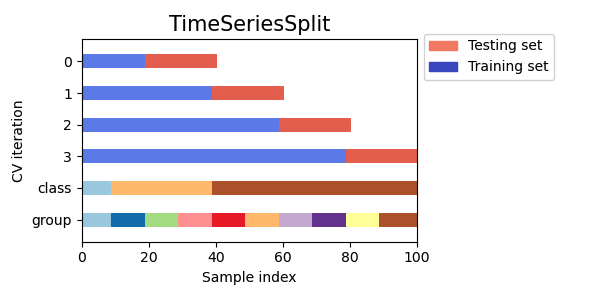

## Augmented Dickey-Fuller Test 
- To be continued:
- Test for stationairity

Stationarity at is simplest- Auto-covaraiance and time are independent. 

https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

In [25]:
for i in range(len(df.columns)):
    adf, p, usedlag, nobs, cvs, bic = sm.tsa.stattools.adfuller(df.iloc[:,i], autolag = "BIC")
    print(f'{df.columns[i]}\n\t t-stat:{round(adf,2)}, p-val: {round(p,2)}\n\t Maximized IC: {round(bic,2)}\n\t Used Lag: {round(usedlag,2)}')
    

3 MO
	 t-stat:-0.72, p-val: 0.84
	 Maximized IC: -21817.11
	 Used Lag: 22
6 MO
	 t-stat:-0.82, p-val: 0.81
	 Maximized IC: -24135.47
	 Used Lag: 23
1 YR
	 t-stat:-0.47, p-val: 0.9
	 Maximized IC: -23425.69
	 Used Lag: 1
2 YR
	 t-stat:-0.65, p-val: 0.86
	 Maximized IC: -20215.45
	 Used Lag: 0
3 YR
	 t-stat:-0.73, p-val: 0.84
	 Maximized IC: -19366.96
	 Used Lag: 0
5 YR
	 t-stat:-0.83, p-val: 0.81
	 Maximized IC: -18595.47
	 Used Lag: 0
7 YR
	 t-stat:-0.86, p-val: 0.8
	 Maximized IC: -18475.6
	 Used Lag: 0
10 YR
	 t-stat:-0.84, p-val: 0.81
	 Maximized IC: -19122.61
	 Used Lag: 0
20 YR
	 t-stat:-0.8, p-val: 0.82
	 Maximized IC: -19893.67
	 Used Lag: 0


### Naive testing: Predicting the next day's yield as the previous days
- A useful baseline which sounds trivial but can sometimes be difficult to surpass

There appears to be a unit root for all of our features (maturities) in the dataset. Lets use **PACF** to test for the maximum lags, it is commond for ADF test to return lagged values of 0.

We will use the maximum number of lags for ease of implementation. This will produce a 3D tensor of (Number of Samples, Lags, Features) 

In [26]:
max_ = 0

for i in range(len(df.columns)):
    pacf = sm.tsa.stattools.pacf(df.iloc[:,i], nlags=30)
    N = len(df.iloc[:,i])
    sig_test = lambda x: np.abs(x) > 1.96/np.sqrt(N)
    
    for j in range(len(pacf)):
        if max_ < n_steps:
                max_ = n_steps
        if sig_test(pacf[j]) == False:
            n_steps = j - 1
            break
            
print(f'The appropriate Number of steps for {[i for i in df.columns]}  set to {max_} lags')


NameError: name 'n_steps' is not defined

In [362]:
def lagfeatures(df, lags, steps):
    """
    df: pandas DataFrame
    lags: number of lags, i.e. sequence length
    steps: forecasting horizon
    
    """
    lag_list = []
    for lag in range(lags + steps - 1, steps - 1, -1):
        lag_list.append(df.shift(lag))
    
    lagarr = np.dstack([l[lags+steps-1:-1] for l in lag_list])
    
    # Right now, columns are insterted as rows. We need to flip the axes.
    return lagarr

In [363]:
def step_output(df, lags, steps):
    """
    df: pandas DataFrame
    lags: number of lags, i.e. sequence length
    steps: forecasting horizon
    
    """
    step_list = []
    for step in range(steps,0, -1): #KNOW THIS
        step_list.append(df.shift(step))
    step_arr = np.dstack([l[lags+steps:] for l in step_list])

    return step_arr

In [364]:
lags = 30
steps = 5

Xtrain = lagfeatures(df_train, 320, 5)
Ytrain = step_output(df_train, 30, 5)
Xtest = lagfeatures(df_test, 30, 5)
Ytest = step_output(df_test, 30, 5)

print(f'{np.shape(Xtrain)} has a tensor dimension of 3 and it represents Obervations, Lags, and Features')
print(f'{np.shape(Ytrain)} has tensor dimension of 2 and it represents (Obervations and Timesteps)')
print(f'{np.shape(Xtest)} has a tensor dimension of 3 and it represents Obervations, Lags, and Features')
print(f'{np.shape(Ytest)} has tensor dimension of 2 and it represents (Obervations and Timesteps)')

(5354, 9, 30) has a tensor dimension of 3 and it represents Obervations, Lags, and Features
(5354, 9, 5) has tensor dimension of 2 and it represents (Obervations and Timesteps)
(1313, 9, 30) has a tensor dimension of 3 and it represents Obervations, Lags, and Features
(1313, 9, 5) has tensor dimension of 2 and it represents (Obervations and Timesteps)


In [369]:
new = df.iloc[:30,:]
new

,level_0,index,Date,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR
0,0,0,1993-10-01,2.98,3.11,3.35,3.84,4.18,4.72,5.03,5.34,6.12
1,1,1,1993-10-04,3.02,3.17,3.35,3.85,4.16,4.71,5.04,5.34,6.10
2,2,2,1993-10-05,3.06,3.20,3.38,3.86,4.18,4.72,5.05,5.35,6.12
3,3,3,1993-10-06,3.04,3.19,3.36,3.85,4.16,4.70,5.05,5.35,6.12
4,4,4,1993-10-07,3.05,3.17,3.35,3.83,4.15,4.69,5.05,5.33,6.11
5,5,5,1993-10-08,3.05,3.16,3.33,3.78,4.09,4.61,4.96,5.26,6.02
6,6,6,1993-10-12,3.12,3.21,3.36,3.82,4.11,4.64,4.97,5.27,6.02
7,7,7,1993-10-13,3.10,3.20,3.36,3.84,4.11,4.64,4.98,5.27,6.03
8,8,8,1993-10-14,3.08,3.18,3.36,3.82,4.09,4.61,4.93,5.23,5.98
9,9,9,1993-10-15,3.08,3.18,3.35,3.81,4.06,4.57,4.90,5.19,5.91


### Scale into true percentile format

In [370]:
for tensor in (Xtrain, Ytrain, Xtest, Ytest):
    tensor/=100

### Construct a 'Naive' Baseline Prediction
Let's see if our model can beat a simple model prediction. 
How about predicting the next 5 days of the yield curve. At time index `t`, will predict the next `t+5` days. So we will use the values of `t` and repeat them to predict the next `t + 5` days. The shapes of both should be (5, 9) or `(Steps, Features)`


In [371]:
def naive_prediction(arr, steps):
    '''
    arr- Training Array
    steps - How many steps to predict
    
    Return: mae_pred, a (steps,feature) tensor  
    '''
    #Each mean absolute error for each prediction
    agg_maes = []
    for i in range(1,len(Xtrain)-steps + 1):
        idx = i-1
        ypred = np.array([Xtrain[idx ,:,0]]* steps) #Shape of (5,9). Each row of the array will be the same.
        y = np.array([Xtrain[i:i + steps,:,0],]) # Shape of (5, 9)
        mae =np.mean(np.abs(y - ypred), axis = 0)# Return mean of each column, now (1,9) 
        agg_maes.append(mae)
        mae_pred = np.mean(agg_maes, axis = 0)
    return mae_pred

In [372]:
naive_error = naive_prediction(Xtrain, 5)

In [373]:
np.set_printoptions(suppress=True,precision = 7) #Not in scientific notation

In [374]:
for i in range(len(naive_error)):
    print(f'{i+1} time step(s) ahead obtained an average error of \n {naive_error[i]}')

1 time step(s) ahead obtained an average error of 
 [0.0002609 0.000241  0.0002796 0.0003908 0.0004309 0.0004678 0.0004761
 0.0004552 0.0004277]
2 time step(s) ahead obtained an average error of 
 [0.0003971 0.0003565 0.0004097 0.0005707 0.0006273 0.0006808 0.0006902
 0.0006589 0.0006101]
3 time step(s) ahead obtained an average error of 
 [0.0004791 0.0004343 0.0005042 0.0006929 0.0007661 0.000831  0.0008426
 0.0008042 0.0007459]
4 time step(s) ahead obtained an average error of 
 [0.0005331 0.0004948 0.0005832 0.0007978 0.0008842 0.0009595 0.0009746
 0.0009351 0.0008648]
5 time step(s) ahead obtained an average error of 
 [0.0005929 0.0005523 0.0006564 0.0008874 0.0009838 0.0010679 0.0010835
 0.0010394 0.0009647]


In [375]:
feature_avg = np.mean(naive_error, axis = 1)
print(f'Mean Absolute Errorfor each feature: {[(term , mae) for term ,mae in zip(df.columns,feature_avg)]}')

Mean Absolute Errorfor each feature: [('level_0', 0.00038112627490080933), ('index', 0.0005557051162211129), ('Date', 0.000677798550092455), ('3 MO', 0.0007807876861718882), ('6 MO', 0.0008698053634116644)]


In [376]:
step_avg = np.mean(naive_error, axis = 0)
print(f'Mean Absolute Error for each feature: {[(steps + 1 , mae) for steps ,mae in zip(range(steps),step_avg)]}')

Mean Absolute Error for each feature: [(1, 0.00045261170312209273), (2, 0.00041580108431483337), (3, 0.00048660684240046676), (4, 0.0006679192372406221), (5, 0.0007384670031781802)]


In [377]:
np.mean(naive_error)

0.0006530445981595859

In [415]:
model = tf.keras.models.Sequential()
model.add(LSTM(units = 64,return_sequences=True,input_shape=Xtrain.shape[-2:]))
model.add(Dropout(0.5))
model.add(LSTM(units = 64,return_sequences=True,input_shape=Xtrain.shape[-2:]))
model.add(Dense(5))
model.compile(optimizer='rmsprop', clipvalue=1.0), loss='mae')
print(model.summary())

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_72 (LSTM)               (None, 9, 64)             24320     
_________________________________________________________________
dropout (Dropout)            (None, 9, 64)             0         
_________________________________________________________________
lstm_73 (LSTM)               (None, 9, 64)             33024     
_________________________________________________________________
dense_34 (Dense)             (None, 9, 5)              325       
Total params: 57,669
Trainable params: 57,669
Non-trainable params: 0
_________________________________________________________________
None


In [414]:
early_stopping = EarlyStopping(monitor='loss', patience = 7, restore_best_weights=True)

history = model.fit(Xtrain,Ytrain,
                                          epochs=20,
                                          callbacks=[early_stopping])

Epoch 1/20
168/168 [==============================] - 3s 15ms/step - loss: 0.0077
Epoch 2/20
168/168 [==============================] - 3s 15ms/step - loss: 0.0036
Epoch 3/20
168/168 [==============================] - 3s 15ms/step - loss: 0.0029
Epoch 4/20
168/168 [==============================] - 3s 15ms/step - loss: 0.0026
Epoch 5/20
168/168 [==============================] - 2s 15ms/step - loss: 0.0024
Epoch 6/20
168/168 [==============================] - 3s 15ms/step - loss: 0.0023
Epoch 7/20
168/168 [==============================] - 3s 15ms/step - loss: 0.0022
Epoch 8/20
168/168 [==============================] - 3s 15ms/step - loss: 0.0021
Epoch 9/20
168/168 [==============================] - 3s 15ms/step - loss: 0.0021
Epoch 10/20
168/168 [==============================] - 3s 16ms/step - loss: 0.0020
Epoch 11/20
168/168 [==============================] - 3s 15ms/step - loss: 0.0020
Epoch 12/20
168/168 [==============================] - 3s 17ms/step - loss: 0.0019
Epoch 13/20
1

"An experience researcher who knows
the art of forecasting should apply
the NN models as a great care is
required for selection of architecture
of the NN models such as number of
hidden layers, number of input
variables, number of neuron,
selection of activation functions,
starting values of the weights, type
of training, optimization algorithm,
choice of learning rate and
momentum term and stopping rule.
For finding the appropriate model
the researcher needs a rush of
refitting the NN model." 
https://arxiv.org/pdf/1010.3501.pdf